<a href="https://colab.research.google.com/github/Ocrabit/sao-guidance/blob/main/melody/Colab-Friendly-guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regular `pip` is slow, but can be a bit more robust than `uv`

`pandas` may take a while to install. If you get "Runtime Disconnected" just resume and re-run the previous command.

Though sometimes "Runtime Disconnected" is a false message and you're still actually connected! (??)

## IGNORE ANY ERRORS AND JUST KEEP GOING.

You may need to restart at least once though (see below)

In [ ]:
!pip install sentencepiece protobuf numpy pandas PyWavelets torch==2.8.0 torchaudio torchmetrics transformers | grep -v 'already satisfied'

In [ ]:
!pip install alias-free-torch==0.0.6 descript-audio-codec==1.0.0 einops einops-exts ema-pytorch==0.2.3 'gradio>=5.20.0' huggingface_hub 'importlib-resources>=5.12.0' k-diffusion==0.1.1 local-attention==1.8.6 prefigure==0.0.9 pytorch_lightning==2.1.0 safetensors sentencepiece v-diffusion-pytorch==0.0.2 vector-quantize-pytorch==1.14.41 'wandb>=0.15.4' 'webdataset>=0.2.100' torchcodec matplotlib librosa julius | grep -v 'already satisfied'

# ^ IGNORE ERRORS.  Restart if prompted. Keep going.

In [ ]:
!pip install auraloss==0.4.0 encodec==0.1.1 laion-clap==1.1.4 --no-deps  | grep -v 'already satisfied'

In [ ]:
!pip install stable-audio-tools --no-deps  | grep -v 'already satisfied'

In [ ]:
!pip install -U  protobuf

STOP.  Restart Runtime, then refresh browser page

In [1]:
import stable_audio_tools
print("Success!")

Success!


In [2]:
#import numpy as np
import torch
import torchaudio
from einops import rearrange
from stable_audio_tools import get_pretrained_model
from stable_audio_tools.inference.generation import generate_diffusion_cond
from IPython.display import Audio


device = "cuda" if torch.cuda.is_available() else "mps"if torch.backends.mps.is_available() else "cpu"
print("device = ",device)

device =  cuda


In [3]:
from huggingface_hub import login

token = "######__REPLACE_WITH_YOUR_HUGGINGFACE_MODEL_API_TOKEN__######"
login(token=token)

In [ ]:
# Download model
model, model_config = get_pretrained_model("stabilityai/stable-audio-open-small")
print("model_config=",model_config)
sample_rate = model_config["sample_rate"]
sample_size = model_config["sample_size"]
model = model.to(device)

## ^^^ IGNORE ANY ERRORS. Keep going!

In [5]:
# Set up text and timing conditioning
conditioning = [{
    "prompt": "60 BPM jazz saxophone solo",
    "seconds_total": 11
}]

In [6]:
# Generate stereo audio
output = generate_diffusion_cond(
    model,
    steps=8,
    cfg_scale=1.0,
    conditioning=conditioning,
    sample_size=sample_size,
    sampler_type="pingpong",
    device=device,
    callback=None,
)
# Rearrange audio batch to a single sequence
output = rearrange(output, "b d n -> d (b n)")

2709410360


/usr/local/lib/python3.12/dist-packages/stable_audio_tools/models/conditioners.py:362: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16) and torch.set_grad_enabled(self.enable_grad):
100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


In [ ]:
output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
torchaudio.save("output.wav", output, sample_rate)

In [8]:
Audio("output.wav")

In [9]:
!git clone https://github.com/Ocrabit/torchcrepe.git torchcrepe_package

Cloning into 'torchcrepe_package'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 472 (delta 165), reused 151 (delta 151), pack-reused 281 (from 3)
Receiving objects: 100% (472/472), 72.22 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [ ]:
!pip install -e ./torchcrepe_package

In [ ]:
%cd /content/torchcrepe_package
!pip install -e .

In [45]:
import torch
import torchaudio
import torchcrepe
from einops import rearrange
from stable_audio_tools import get_pretrained_model
from stable_audio_tools.inference.generation import generate_diffusion_cond
from stable_audio_tools.inference import sampling
from tqdm.auto import trange
import numpy as np
import math
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf
from torch.nn import MSELoss
import os
import urllib

In [50]:
LINE_WIDTH = 2

@torch.enable_grad()
def calculate_pitch(audio, sample_rate, model_type='tiny'):
    # Compute pitch
    if isinstance(audio, np.ndarray):
        audio = torch.tensor(audio, device=device, dtype=torch.float32)

    if audio.ndim > 1:
        audio = audio.to(device=device, dtype=torch.float32).mean(dim=0, keepdim=True)

    hop = int(sample_rate / 500.)  # 5 ms hop
    pitch, periodicity = torchcrepe.predict(audio, sample_rate, hop_length=hop, fmin=50, fmax=550,
                            model=model_type, # or 'full'
                            batch_size=4096, device=device, return_periodicity=True, decoder=torchcrepe.decode.soft_argmax, differentiable=True)
    # Clean up pitch
    win_l = 3
    periodicity = torchcrepe.filter.median(periodicity, win_l)
    # periodicity = torchcrepe.threshold.Silence(-60.)(periodicity, audio, sample_rate, hop)
    pitch = torchcrepe.threshold.At(.5)(pitch, periodicity)
    pitch = torchcrepe.filter.mean(pitch, win_l)
    return pitch

def get_github_audio(url, filename=None):
    """Download a GitHub audio file to data/audio/ if missing and return its path."""
    os.makedirs("data/audio", exist_ok=True)
    if not filename:
        filename = os.path.basename(url)
    path = os.path.join("data/audio", filename)

    if not os.path.exists(path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, path)
        print(f"Saved to {path}")
    else:
        print(f"Using cached file: {path}")
    return path

def plot_pitch(pitch, sample_rate, hop_length=None):
    if hop_length is None:
        hop_length = int(sample_rate / 200.)

    if torch.is_tensor(pitch):
        pitch = pitch[0].cpu().detach().numpy()

    times = np.arange(len(pitch)) * hop_length / sample_rate

    plt.figure(figsize=(10, 4))
    plt.plot(times, pitch, linewidth=LINE_WIDTH)
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")
    plt.title("Pitch Contour")
    plt.show()

In [ ]:
# if you don't have the audio file download it
get_github_audio("https://github.com/pdx-cs-sound/wavs/raw/refs/heads/main/gc.wav")

target_audio, target_sr = torchaudio.load('data/audio/gc.wav')
if sample_rate != target_sr: # Resample to model rate
    resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
    target_audio = resampler(target_audio)

# Reduce to this really specific time that stable audio open small has
time_sec = 11.888616780045352
target_audio = target_audio[:, :int(time_sec * sample_rate)]
target_pitch = calculate_pitch(target_audio, sample_rate, 'tiny')

print(f"Target length is: {target_audio.shape[1] / sample_rate}")

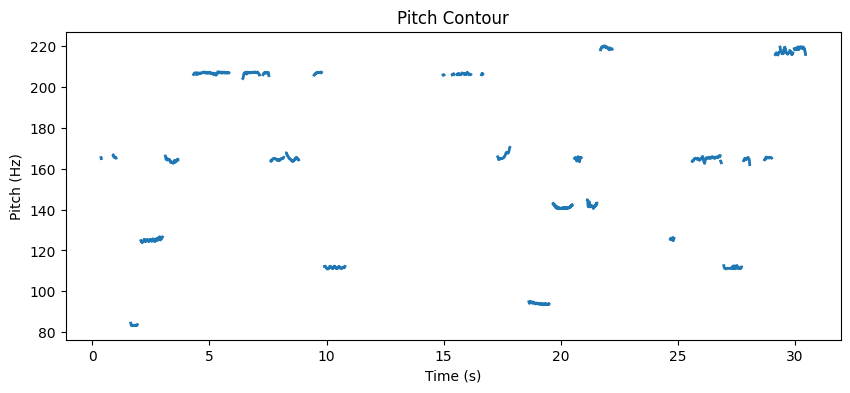

In [51]:
# now lets plot the target_pitch
plot_pitch(target_pitch, sample_rate)

In [53]:
from functools import partial

def pitch_callback(autoencoder, target_pitch, base_step_scale, alpha, inner_strength, in_dict):
    x, denoised, t = in_dict['x'], in_dict['denoised'], in_dict['t'].detach().float()

    step = in_dict['i'] # grab step
    pbar = in_dict.get('pbar', None) # I updated stable-audio-tools to return this in in_dict

    # PnP-Flow schedule: (1 - t)^alpha
    time_weight = (1.0 - t) ** alpha
    step_scale  = base_step_scale * time_weight
    inner_strength = inner_strength
    # print(f"time_weight = {float(time_weight):.4f}, step_scale = {float(step_scale):.4f}, inner_strength = {float(inner_strength):.2f}")

    with torch.enable_grad():
        denoised.requires_grad_(True)
        # print(f"t = {in_dict['t']:.3f}, denoised..shape, .requires_grad = {denoised.shape},, {denoised.requires_grad}")

        pred_audio = autoencoder.decoder(denoised.half()).float() # convert to float 32

        shape_save = pred_audio.shape[-1]
        kernel_size = 64
        pred_audio = torch.nn.functional.avg_pool1d(
            pred_audio, kernel_size=kernel_size, stride=1, padding=kernel_size//2
        )
        pred_audio = pred_audio[..., :shape_save]

        # print(f"Decoder Audio \nshape: {audio.shape} \ndtype: {audio.dtype}")
        pred_audio = rearrange(pred_audio, "b d n -> d (b n)")
        # print("Generated Audio shape:", audio.shape, f"Generated Audio length: {(audio.shape[1]/sample_rate):.2f}")

        # Display audio at each step
        diplay_audio = pred_audio.div(torch.max(torch.abs(pred_audio))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()
        # how stable audio converted it
        # display(Audio(diplay_audio.numpy(), rate=sample_rate))

        # Compute pitch
        pred_audio = pred_audio.mean(dim=0, keepdim=True)
        pitch = calculate_pitch(pred_audio, sample_rate, 'tiny')

        loss_fn = MSELoss()
        loss = loss_fn(torch.nan_to_num(pitch, nan=0.),
                        torch.nan_to_num(target_pitch, nan=0.))
        # print(f"diff scale {torch.nan_to_num(pitch, nan=0.).std()}")
        # loss = mse_loss + 0.01 * (1.0 / (torch.nan_to_num(pitch, nan=0.).std() + 1e-6))

        # Graph both pitch
        if step % 10 == 0:  # lets save every ten
            pitch_array.append(pitch.detach().cpu().numpy()) # make sure to use this in jupter for external context
            audio_array.append(diplay_audio.detach().cpu().numpy())
            # plot_pitch_comparison(pitch, target_pitch, sample_rate, overlay=True)

        grad_x = torch.autograd.grad(loss, denoised, grad_outputs=torch.ones_like(loss), retain_graph=False, allow_unused=True)[0]
        # d_denoised = -step_scale * grad_x
        if grad_x is None:
            print("Warning: grad_x is None (no gradient path from pitch to denoised)")
            return

        print(f"loss {loss.item()}")
        with torch.no_grad():
            grad_norm = grad_x.norm()
            if torch.isfinite(grad_norm) and grad_norm > 0.1:
                grad_x = grad_x * (0.1 / grad_norm)
            # denoised -= step_scale * grad_x
            denoised.add_(-inner_strength * step_scale * grad_x)
            denoised.requires_grad_(False)

            # print(f"loss={loss.item():.6f}")
            if pbar is not None:
                # pbar.set_postfix({'one': 1, 'two': 2})
                # print(pbar.postfix)
                pbar.set_postfix({**({k.strip(): v.strip() for k, v in (item.split('=') for item in pbar.postfix.split(','))}
                                     if pbar.postfix else {}),  'loss': f"{loss.item():.2f}"})

# def cfg_scheduler(cfg_scale, step, p=.4, k =.5):
#     # return min(max(0.0, cfg_scale), (math.log(step) ** 2)/100)
#     return cfg_scale * math.exp(-k * (step / math.exp(p)))

def cfg_scheduler(cfg_scale, step, cutoff=5, middle_descend=2):
    if step < cutoff:
        return cfg_scale
    elif step < cutoff + middle_descend:
        return cfg_scale * (middle_descend - (step - cutoff)) / middle_descend
    else:
        return 0.0

In [54]:
# monkey Patch pingpon
@torch.no_grad()
def sample_flow_pingpong(model, x, steps=None, sigma_max=1, sigmas=None, callback=None, dist_shift=None, **extra_args):
    """Draws samples from a model given starting noise. Ping-pong sampling for distilled models"""

    assert steps is not None or sigmas is not None, "Either steps or sigmas must be provided"

    # Make tensor of ones to broadcast the single t values
    ts = x.new_ones([x.shape[0]])

    if sigmas is None:

        # Create the noise schedule
        t = torch.linspace(sigma_max, 0, steps + 1)

        if dist_shift is not None:
            t = dist_shift.time_shift(t, x.shape[-1])

    else:
        t = sigmas

    # Add pbar to in_dict and set a cfg_scale to reduce to 0 with time
    cfg_scheduler = extra_args.pop("cfg_scheduler", None)
    if cfg_scheduler: base_cfg = float(extra_args.pop("cfg_scale", 0.0))

    pbar = trange(len(t) - 1, desc="Sampling")
    for i in pbar:
        if cfg_scheduler:
            scheduled_cfg = cfg_scheduler(base_cfg, i + 1)
            extra_args["cfg_scale"] = scheduled_cfg  # replace cfg_scale with scheduled_cfg
            pbar.set_postfix({**({k.strip(): v.strip()
                                for k, v in (item.split('=') for item in pbar.postfix.split(','))} if pbar.postfix else {}),
                            'cfg_scale': f"{scheduled_cfg:.2f}"})  # utterly absurd

        denoised = x - t[i] * model(x, t[i] * ts, **extra_args)
        if callback is not None:
            callback({'x': x, 'i': i, 't': t[i], 'sigma': t[i], 'sigma_hat': t[i], 'denoised': denoised, 'pbar': pbar})

        t_next = t[i + 1]
        x = (1 - t_next) * denoised + t_next * torch.randn_like(x)

    return x

sampling.sample_flow_pingpong = sample_flow_pingpong

In [ ]:
conditioning = [{
    "prompt": "nylon guitar country sound",  # This prompt is quite bad on small, but small does work
    "seconds_total": time_sec
}]
pitch_array = []
audio_array = []

autoencoder = model._modules['pretransform']._modules.get("model")
# Params
base_step_scale = 5
alpha = 5
inner_strength = 50
callback_wrapper = partial(pitch_callback, autoencoder, target_pitch, base_step_scale, alpha, inner_strength)
cfg_scheduler_wrapper = partial(cfg_scheduler, cutoff=20, middle_descend=2)

# callback_wrapper = partial(pitch_guidance_callback, autoencoder, target_pitch, 50)

# Generate stereo audio
output = generate_diffusion_cond(
    model,
    # Marco's Notes:
    # 7 steps works good for sao small, higher than that gets scary
    # If using normal sao higher steps is usually pretty good.
    conditioning=conditioning,
    steps=30,
    cfg_scale=10, # Config of 1 often good for small, higher works on normal
    sample_size=sample_size,
    sigma_min=10,
    sigma_max=300,
    # sampler_type="dpmpp-3m-sde",  # Use this for normal open
    sampler_type="pingpong",  # Use this for small
    device=device,
    callback=callback_wrapper,
    cfg_scheduler=cfg_scheduler_wrapper
)

# Rearrange audio batch to a single sequence
output = rearrange(output, "b d n -> d (b n)")

In [ ]:
# Peak normalize, convert to int16
cleaned_output = output.to(torch.float32).div(torch.max(torch.abs(output))).clamp(-1, 1).mul(32767).to(torch.int16).cpu()

# Clip length
#clipped_output = cleaned_output[..., :int(sample_rate * total_seconds)]

Audio(cleaned_output.numpy(), rate=sample_rate)

In [ ]:
from google.colab import files
files.download("colab_output.wav")

In [67]:
sf.write("colab_output.wav", cleaned_output.T, sample_rate, subtype="PCM_16")

In [ ]:
Audio("colab_output.wav", rate=sample_rate)